In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical

def load_data_from_mat(path):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    for file in os.listdir(path):
        if file.startswith('train_'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            train_data.append(mat[list(mat.keys())[-2]])  # Assuming data is the second last key
            train_labels.append(mat[list(mat.keys())[-1]])  # Assuming label is the last key
        elif file.startswith('test_'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            test_data.append(mat[list(mat.keys())[-2]])
            test_labels.append(mat[list(mat.keys())[-1]])

    # Concatenate all data and labels respectively
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # Normalize data
    train_data = train_data.astype('float32') / 255
    test_data = test_data.astype('float32') / 255

    # Convert labels to categorical (one-hot encoding)
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_data, train_labels, test_data, test_labels


def apply_fft_and_split(data):
    """
    对数据执行一维FFT变换，并分离实部和虚部。
    
    Parameters:
    - data: 形状为 (n_samples, n_features) 的数组
    
    Returns:
    - FFT变换后数据的实部和虚部
    """
    fft_data = np.fft.fft(data, axis=-1)
    return np.real(fft_data), np.imag(fft_data)

In [5]:
# 调用函数加载数据
path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/'
train_data, train_labels, test_data, test_labels = load_data_from_mat(path)

train_data_origin = train_data
test_data_origin = test_data

# train_data_z = train_data / np.max(train_data)
# test_data_z = test_data / np.max(test_data)

# 应用FFT变换并分离实部和虚部
train_data_fft_real, train_data_fft_imag = apply_fft_and_split(train_data)
test_data_fft_real, test_data_fft_imag = apply_fft_and_split(test_data)

# 合并实部和虚部为模型的输入
train_data_fft_combined = np.concatenate((train_data_fft_real, train_data_fft_imag), axis=-1)
test_data_fft_combined = np.concatenate((test_data_fft_real, test_data_fft_imag), axis=-1)

def compute_magnitude_phase(data_fft_real, data_fft_imag):
    magnitude = np.sqrt(data_fft_real**2 + data_fft_imag**2)
    phase = np.arctan2(data_fft_imag, data_fft_real)
    return magnitude, phase

# 假设 train_data_fft_real 和 train_data_fft_imag 是你之前计算的FFT变换的实部和虚部
train_magnitude, train_phase = compute_magnitude_phase(train_data_fft_real, train_data_fft_imag)
test_magnitude, test_phase = compute_magnitude_phase(test_data_fft_real, test_data_fft_imag)

# 将幅度和相位合并为模型输入
# train_data_combined = np.concatenate((train_magnitude, train_phase), axis=-1)
# test_data_combined = np.concatenate((train_magnitude, train_phase), axis=-1)

half_train_magnitude = train_magnitude[:, :1536]
half_test_magnitude = test_magnitude[:, :1536]
half_train_data_fft_real = train_data_fft_real[:, :1536]
half_train_data_fft_imag = train_data_fft_imag[:, :1536]
half_test_data_fft_real = test_data_fft_real[:, :1536]
half_test_data_fft_imag = test_data_fft_imag[:, :1536]
# print(train_magnitude.shape)
# print(half_train_phase.shape)
# 然后可以用这些数据来训练你的模型
train_data_combined = np.concatenate((half_train_magnitude, half_train_data_fft_real, half_train_data_fft_imag), axis=-1)
test_data_combined = np.concatenate((half_test_magnitude, half_test_data_fft_real, half_test_data_fft_imag), axis=-1)
print(train_data_combined.shape)
print(test_data_combined.shape)
# train_data_fft_combined = np.concatenate((train_data_origin, train_data_combined), axis=-1)
# test_data_fft_combined = np.concatenate((test_data_origin, test_data_combined), axis=-1)
# print(train_data_fft_combined.shape)
# print(test_data_fft_combined.shape)
# print('Train data shape:', train_data_combined.shape)
# print('Train labels shape:', train_labels.shape)
# print('Test data shape:', test_data_combined.shape)
# print('Test labels shape:', test_labels.shape)
# # 根据FFT结果调整数据形状，此处仅为示例，实际需要根据FFT变换后的数据形状进行调整


(126000, 4608)
(14000, 4608)


In [6]:
# train_data_fft_reshaped = train_data_fft_combined.reshape((-1, 32, 48, 4))
# test_data_fft_reshaped = test_data_fft_combined.reshape((-1, 32, 48, 4))
train_data_fft_reshaped = train_data_combined.reshape((-1, 32, 48, 3))
test_data_fft_reshaped = test_data_combined.reshape((-1, 32, 48, 3))
print('Train data shape:', train_data_fft_reshaped.shape)
print('Test data shape:', test_data_fft_reshaped.shape)

Train data shape: (126000, 32, 48, 3)
Test data shape: (14000, 32, 48, 3)


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam

def build_mobilenet_like_model(input_shape=(32, 48, 3), num_classes=10):
    model = Sequential([
        # Block 1 - Depthwise Convolution
        DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation=None, input_shape=input_shape),
        BatchNormalization(),
        ReLU(),
        Conv2D(64, (1, 1), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Block 2 - Depthwise Convolution
        DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation=None),
        BatchNormalization(),
        ReLU(),
        Conv2D(128, (1, 1), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Block 3 - Depthwise Convolution
        DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation=None),
        BatchNormalization(),
        ReLU(),
        Conv2D(256, (1, 1), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# 根据加载的数据设置模型
model = build_mobilenet_like_model(input_shape=(32, 48, 3), num_classes=10)

# 编译模型
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 输出模型概况
model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_depthwise_conv.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ depthwise_conv2d_9              │ (None, 32, 48, 3)      │            30 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 48, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 32, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 48, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_10             │ (None, 16, 24, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 16, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 24, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_11             │ (None, 8, 12, 128)     │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 12, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 8, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 12, 256)     │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     3,146,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,195,700 (12.19 MB)

 Trainable params: 3,195,310 (12.19 MB)

 Non-trainable params: 390 (1.52 KB)

In [8]:
# 训练模型
history = model.fit(train_data_fft_reshaped, train_labels,
                    batch_size=64,
                    epochs=30,  # 可以调整为合适的值
                    validation_split=0.1,
                    shuffle=True)



Epoch 1/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 118s 65ms/step - accuracy: 0.4493 - loss: 1.3020 - val_accuracy: 0.6284 - val_loss: 0.7507
Epoch 2/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 116s 65ms/step - accuracy: 0.6006 - loss: 0.8746 - val_accuracy: 0.6679 - val_loss: 0.6671
Epoch 3/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 115s 65ms/step - accuracy: 0.6381 - loss: 0.7864 - val_accuracy: 0.7679 - val_loss: 0.6239
Epoch 4/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 112s 63ms/step - accuracy: 0.6759 - loss: 0.7110 - val_accuracy: 0.8055 - val_loss: 0.5314
Epoch 5/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 113s 64ms/step - accuracy: 0.6908 - loss: 0.6738 - val_accuracy: 0.7240 - val_loss: 0.5084
Epoch 6/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 116s 65ms/step - accuracy: 0.7085 - loss: 0.6406 - val_accuracy: 0.8056 - val_loss: 0.4625
Epoch 7/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 117s 66ms/step - accuracy: 0.7191 - loss: 0.6201 - val_accuracy: 0.7747 - val_loss: 0.5117
Epoch 8/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 114s 64ms/step - accuracy: 

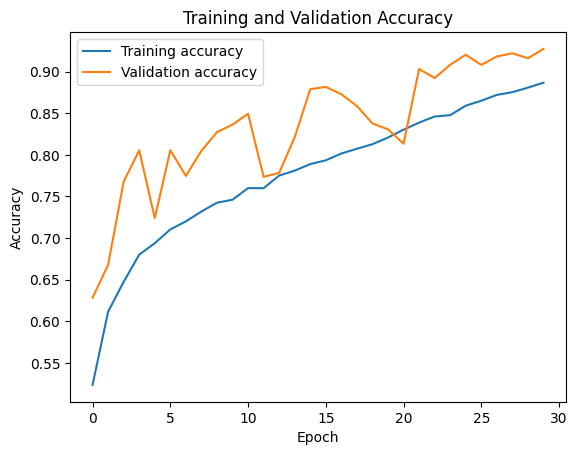

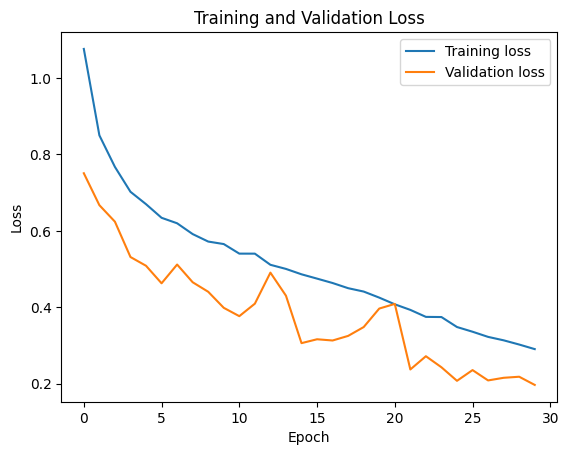

In [9]:
# 可视化训练过程
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
model.save('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/FFT-mobilenet-2.h5')  # HDF5文件


In [11]:
loaded_model = tf.keras.models.load_model('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/FFT-mobilenet-2.h5')
# 评估模型在测试集上的性能
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)

print(f'测试集损失: {test_loss}')
print(f'测试集准确率: {test_acc}')


438/438 - 7s - 16ms/step - accuracy: 0.7664 - loss: 0.5942
测试集损失: 0.5942222476005554
测试集准确率: 0.7664285898208618


438/438 - 7s - 15ms/step - accuracy: 0.7664 - loss: 0.5942

Test accuracy: 0.7664285898208618
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step
              precision    recall  f1-score   support

           0       0.54      0.58      0.56      1400
           1       1.00      1.00      1.00      1400
           2       0.75      0.85      0.80      1400
           3       0.88      0.62      0.73      1400
           4       1.00      1.00      1.00      1400
           5       0.94      0.89      0.91      1400
           6       0.59      0.57      0.58      1400
           7       1.00      1.00      1.00      1400
           8       0.60      0.51      0.55      1400
           9       0.49      0.63      0.55      1400

    accuracy                           0.77     14000
   macro avg       0.78      0.77      0.77     14000
weighted avg       0.78      0.77      0.77     14000



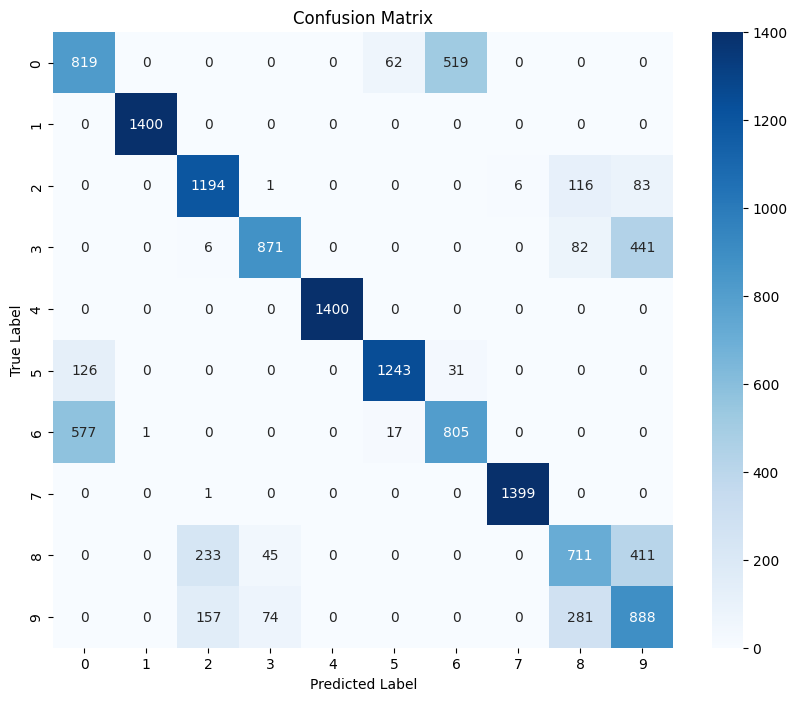

In [12]:
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


(12000, 4608)
375/375 - 7s - 18ms/step - accuracy: 0.7781 - loss: 0.5827

Test accuracy: 0.778083324432373
Test loss: 0.5826804637908936
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
              precision    recall  f1-score   support

           0       0.56      0.59      0.57      1200
           1       1.00      1.00      1.00      1200
           2       0.74      0.84      0.79      1200
           3       0.91      0.63      0.75      1200
           4       1.00      1.00      1.00      1200
           5       0.96      0.93      0.94      1200
           6       0.60      0.58      0.59      1200
           7       1.00      1.00      1.00      1200
           8       0.62      0.57      0.59      1200
           9       0.51      0.64      0.57      1200

    accuracy                           0.78     12000
   macro avg       0.79      0.78      0.78     12000
weighted avg       0.79      0.78      0.78     12000



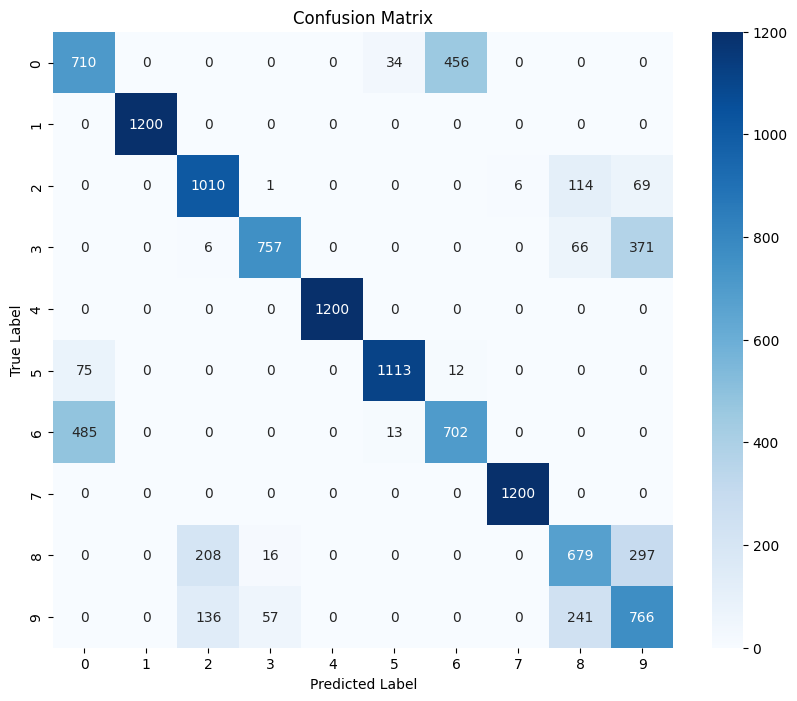

In [13]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/FFT-mobilenet-2.h5')
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def data_geneter_test():
    def load_data_from_mat(path):

        test_data = []
        test_labels = []

        for file in os.listdir(path):
            if file.startswith('test_'):
                mat = scipy.io.loadmat(os.path.join(path, file))
                test_data.append(mat[list(mat.keys())[-2]])
                test_labels.append(mat[list(mat.keys())[-1]])

        # Concatenate all data and labels respectively
        test_data = np.concatenate(test_data, axis=0)
        test_labels = np.concatenate(test_labels, axis=0)

        # Normalize data
        test_data = test_data.astype('float32') / 255

        # Convert labels to categorical (one-hot encoding)
        test_labels = to_categorical(test_labels, 10)

        return test_data, test_labels

    def apply_fft_and_split(data):
        """
        对数据执行一维FFT变换，并分离实部和虚部。
        
        Parameters:
        - data: 形状为 (n_samples, n_features) 的数组
        
        Returns:
        - FFT变换后数据的实部和虚部
        """
        fft_data = np.fft.fft(data, axis=-1)
        return np.real(fft_data), np.imag(fft_data)

    # 调用函数加载数据
    path = '/Users/fuyao/Desktop/Thesis/about_database/generate_database'
    test_data, test_labels = load_data_from_mat(path)


    # 应用FFT变换并分离实部和虚部
    test_data_fft_real, test_data_fft_imag = apply_fft_and_split(test_data)

    def compute_magnitude_phase(data_fft_real, data_fft_imag):
        magnitude = np.sqrt(data_fft_real**2 + data_fft_imag**2)
        phase = np.arctan2(data_fft_imag, data_fft_real)
        return magnitude, phase

    # 假设 train_data_fft_real 和 train_data_fft_imag 是你之前计算的FFT变换的实部和虚部
    test_magnitude, test_phase = compute_magnitude_phase(test_data_fft_real, test_data_fft_imag)


    half_test_magnitude = test_magnitude[:, :1536]
    half_test_data_fft_real = test_data_fft_real[:, :1536]
    half_test_data_fft_imag = test_data_fft_imag[:, :1536]

    # 然后可以用这些数据来训练你的模型

    test_data_combined = np.concatenate((half_test_magnitude, half_test_data_fft_real, half_test_data_fft_imag), axis=-1)

    print(test_data_combined.shape)

    test_data_fft_reshaped = test_data_combined.reshape((-1, 32, 48, 3))

    return test_data_fft_reshaped, test_labels

def data_geneter_test_specific(dNumber):
    def load_data_from_mat(path):

        test_data = []
        test_labels = []

        for file in os.listdir(path):
            if file.startswith(f'test_{dNumber}'):
                mat = scipy.io.loadmat(os.path.join(path, file))
                test_data.append(mat[list(mat.keys())[-2]])
                test_labels.append(mat[list(mat.keys())[-1]])

        # Concatenate all data and labels respectively
        test_data = np.concatenate(test_data, axis=0)
        test_labels = np.concatenate(test_labels, axis=0)

        # Normalize data
        test_data = test_data.astype('float32') / 255

        # Convert labels to categorical (one-hot encoding)
        test_labels = to_categorical(test_labels, 10)

        return test_data, test_labels

    def apply_fft_and_split(data):
        """
        对数据执行一维FFT变换，并分离实部和虚部。
        
        Parameters:
        - data: 形状为 (n_samples, n_features) 的数组
        
        Returns:
        - FFT变换后数据的实部和虚部
        """
        fft_data = np.fft.fft(data, axis=-1)
        return np.real(fft_data), np.imag(fft_data)

    # 调用函数加载数据
    path = '/Users/fuyao/Desktop/Thesis/about_database/generate_database'
    test_data, test_labels = load_data_from_mat(path)


    # 应用FFT变换并分离实部和虚部
    test_data_fft_real, test_data_fft_imag = apply_fft_and_split(test_data)

    def compute_magnitude_phase(data_fft_real, data_fft_imag):
        magnitude = np.sqrt(data_fft_real**2 + data_fft_imag**2)
        phase = np.arctan2(data_fft_imag, data_fft_real)
        return magnitude, phase

    # 假设 train_data_fft_real 和 train_data_fft_imag 是你之前计算的FFT变换的实部和虚部
    test_magnitude, test_phase = compute_magnitude_phase(test_data_fft_real, test_data_fft_imag)


    half_test_magnitude = test_magnitude[:, :1536]
    half_test_data_fft_real = test_data_fft_real[:, :1536]
    half_test_data_fft_imag = test_data_fft_imag[:, :1536]

    # 然后可以用这些数据来训练你的模型

    test_data_combined = np.concatenate((half_test_magnitude, half_test_data_fft_real, half_test_data_fft_imag), axis=-1)

    print(test_data_combined.shape)

    test_data_fft_reshaped = test_data_combined.reshape((-1, 32, 48, 3))

    return test_data_fft_reshaped, test_labels

test_data_fft_reshaped, test_labels = data_geneter_test()
# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
# 评估模型在测试集上的性能
print(f'Test loss: {test_loss}')

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



(2000, 4608)
63/63 - 1s - 20ms/step - accuracy: 0.8190 - loss: 0.4846

Test accuracy: 0.8190000057220459
Test loss: 0.48457685112953186
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

           0       0.61      0.54      0.57       200
           1       1.00      1.00      1.00       200
           2       0.81      0.83      0.82       200
           3       0.98      0.69      0.81       200
           4       1.00      1.00      1.00       200
           5       0.99      0.99      0.99       200
           6       0.59      0.67      0.63       200
           7       1.00      1.00      1.00       200
           8       0.74      0.68      0.71       200
           9       0.59      0.79      0.67       200

    accuracy                           0.82      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.83      0.82      0.82      2000



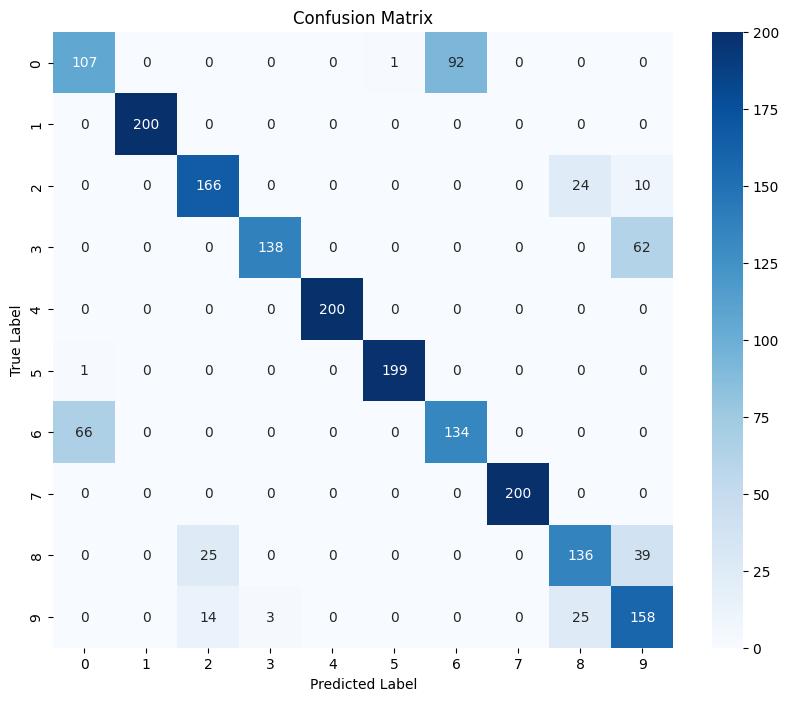

In [14]:
dNumber = 30
test_data_fft_reshaped, test_labels = data_geneter_test_specific(dNumber)
# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
# 评估模型在测试集上的性能
print(f'Test loss: {test_loss}')

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

(2000, 4608)
63/63 - 1s - 18ms/step - accuracy: 0.8135 - loss: 0.5005

Test accuracy: 0.8134999871253967
Test loss: 0.5004590749740601
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

           0       0.62      0.57      0.59       200
           1       1.00      1.00      1.00       200
           2       0.78      0.82      0.80       200
           3       0.97      0.68      0.80       200
           4       1.00      1.00      1.00       200
           5       0.99      0.99      0.99       200
           6       0.61      0.66      0.63       200
           7       1.00      1.00      1.00       200
           8       0.70      0.67      0.68       200
           9       0.58      0.76      0.65       200

    accuracy                           0.81      2000
   macro avg       0.83      0.81      0.82      2000
weighted avg       0.83      0.81      0.82      2000



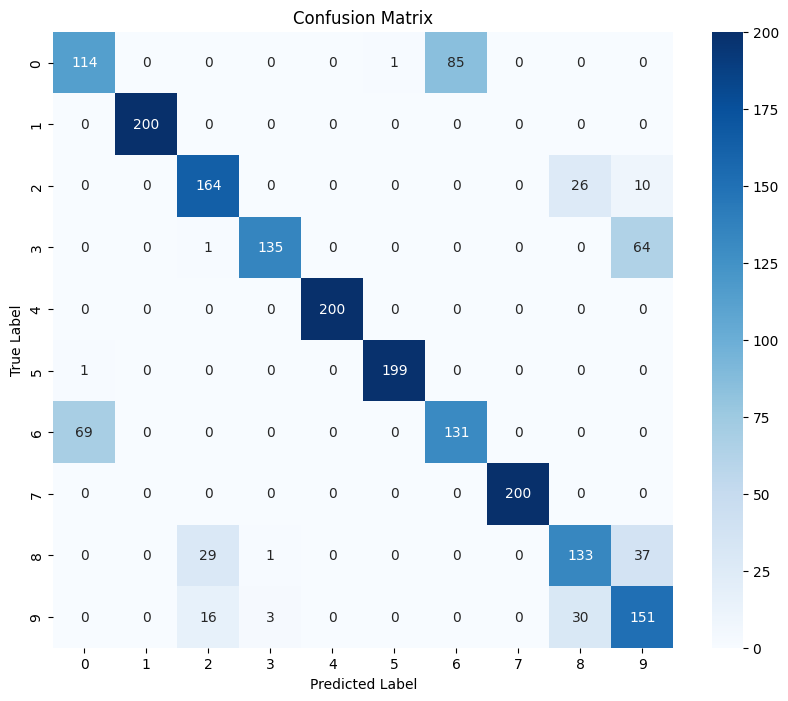

In [15]:
dNumber = 25
test_data_fft_reshaped, test_labels = data_geneter_test_specific(dNumber)
# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
# 评估模型在测试集上的性能
print(f'Test loss: {test_loss}')

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

(2000, 4608)
63/63 - 1s - 19ms/step - accuracy: 0.7980 - loss: 0.5333

Test accuracy: 0.7979999780654907
Test loss: 0.5332503914833069
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       200
           1       1.00      1.00      1.00       200
           2       0.75      0.86      0.80       200
           3       0.95      0.65      0.77       200
           4       1.00      1.00      1.00       200
           5       0.99      0.99      0.99       200
           6       0.61      0.58      0.60       200
           7       1.00      1.00      1.00       200
           8       0.68      0.59      0.63       200
           9       0.52      0.67      0.59       200

    accuracy                           0.80      2000
   macro avg       0.81      0.80      0.80      2000
weighted avg       0.81      0.80      0.80      2000



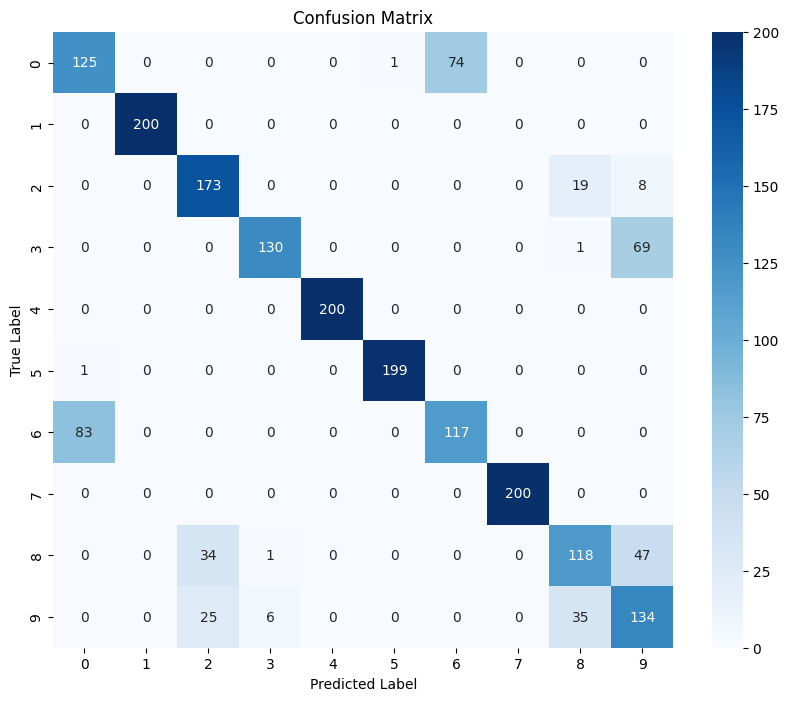

In [16]:
dNumber = 20
test_data_fft_reshaped, test_labels = data_geneter_test_specific(dNumber)
# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
# 评估模型在测试集上的性能
print(f'Test loss: {test_loss}')

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

(2000, 4608)
63/63 - 1s - 17ms/step - accuracy: 0.7785 - loss: 0.6185

Test accuracy: 0.7785000205039978
Test loss: 0.6185019016265869
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       200
           1       1.00      1.00      1.00       200
           2       0.70      0.89      0.79       200
           3       0.93      0.61      0.74       200
           4       1.00      1.00      1.00       200
           5       0.98      0.94      0.96       200
           6       0.62      0.51      0.55       200
           7       1.00      1.00      1.00       200
           8       0.64      0.53      0.58       200
           9       0.50      0.62      0.56       200

    accuracy                           0.78      2000
   macro avg       0.79      0.78      0.78      2000
weighted avg       0.79      0.78      0.78      2000



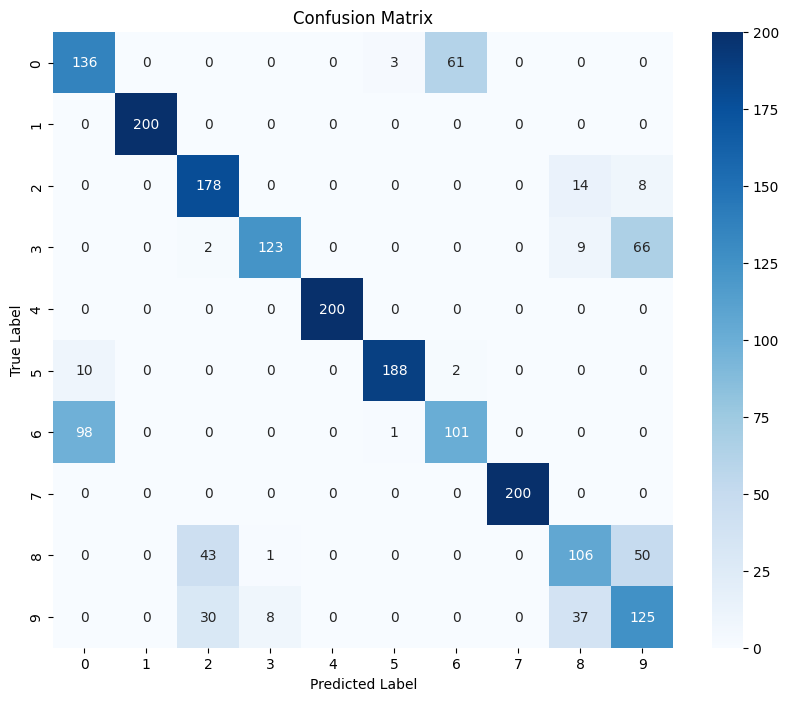

In [17]:
dNumber = 15
test_data_fft_reshaped, test_labels = data_geneter_test_specific(dNumber)
# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
# 评估模型在测试集上的性能
print(f'Test loss: {test_loss}')

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

(2000, 4608)
63/63 - 1s - 18ms/step - accuracy: 0.7545 - loss: 0.6456

Test accuracy: 0.7544999718666077
Test loss: 0.6456050276756287
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

           0       0.53      0.60      0.56       200
           1       1.00      1.00      1.00       200
           2       0.71      0.84      0.77       200
           3       0.86      0.62      0.72       200
           4       1.00      1.00      1.00       200
           5       0.93      0.88      0.90       200
           6       0.60      0.56      0.58       200
           7       0.99      1.00      1.00       200
           8       0.53      0.56      0.54       200
           9       0.47      0.48      0.48       200

    accuracy                           0.75      2000
   macro avg       0.76      0.75      0.76      2000
weighted avg       0.76      0.75      0.76      2000



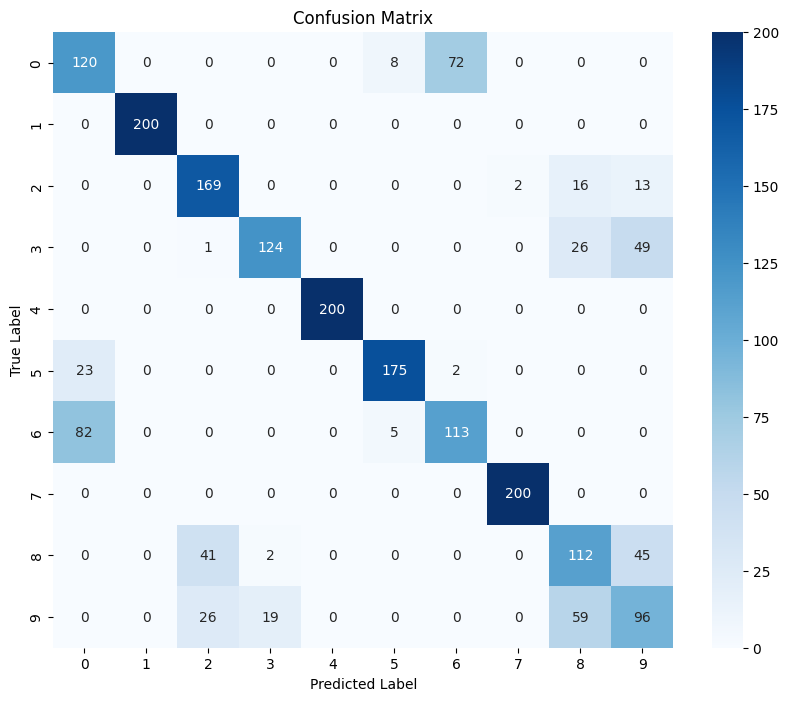

In [18]:
dNumber = 10
test_data_fft_reshaped, test_labels = data_geneter_test_specific(dNumber)
# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
# 评估模型在测试集上的性能
print(f'Test loss: {test_loss}')

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

(2000, 4608)
63/63 - 1s - 17ms/step - accuracy: 0.7050 - loss: 0.7134

Test accuracy: 0.7049999833106995
Test loss: 0.7134084105491638
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
              precision    recall  f1-score   support

           0       0.46      0.54      0.50       200
           1       1.00      1.00      1.00       200
           2       0.72      0.80      0.76       200
           3       0.78      0.54      0.64       200
           4       1.00      1.00      1.00       200
           5       0.85      0.77      0.81       200
           6       0.57      0.53      0.55       200
           7       0.98      1.00      0.99       200
           8       0.43      0.37      0.40       200
           9       0.39      0.51      0.44       200

    accuracy                           0.70      2000
   macro avg       0.72      0.70      0.71      2000
weighted avg       0.72      0.70      0.71      2000



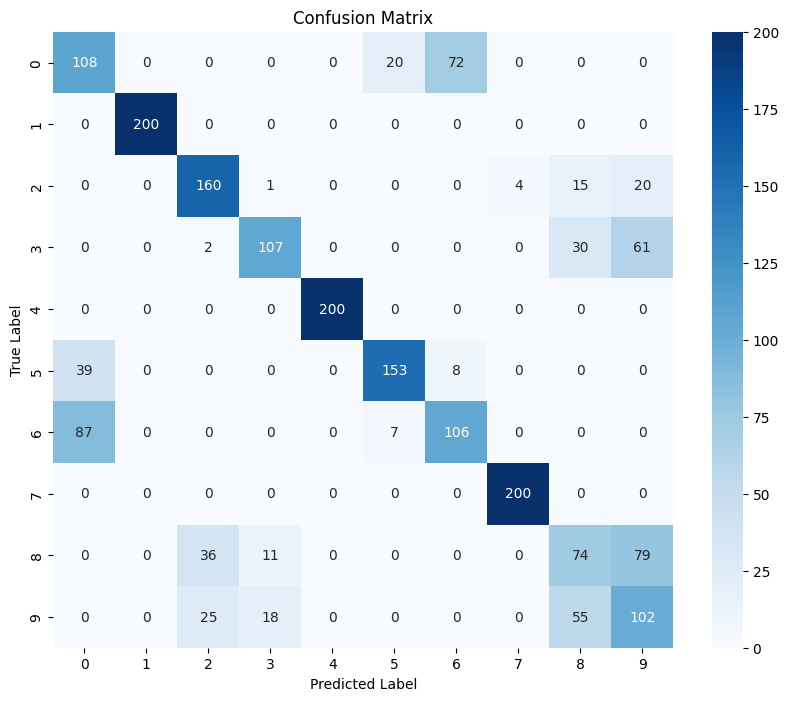

In [19]:
dNumber = 5
test_data_fft_reshaped, test_labels = data_geneter_test_specific(dNumber)
# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
# 评估模型在测试集上的性能
print(f'Test loss: {test_loss}')

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()